Dataset path: /kaggle/input/creditcardfraud
Dataset shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud percentage: 0.1727485630620034


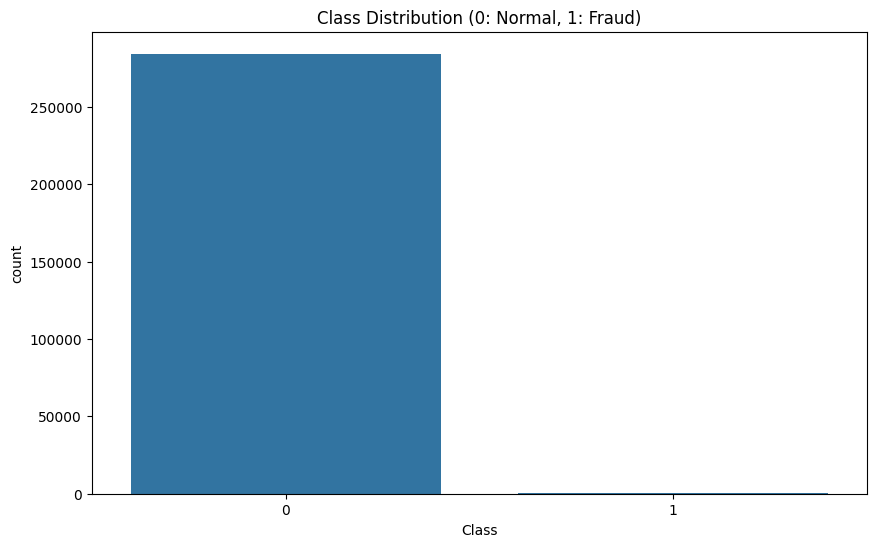

Missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Dataset statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.50000

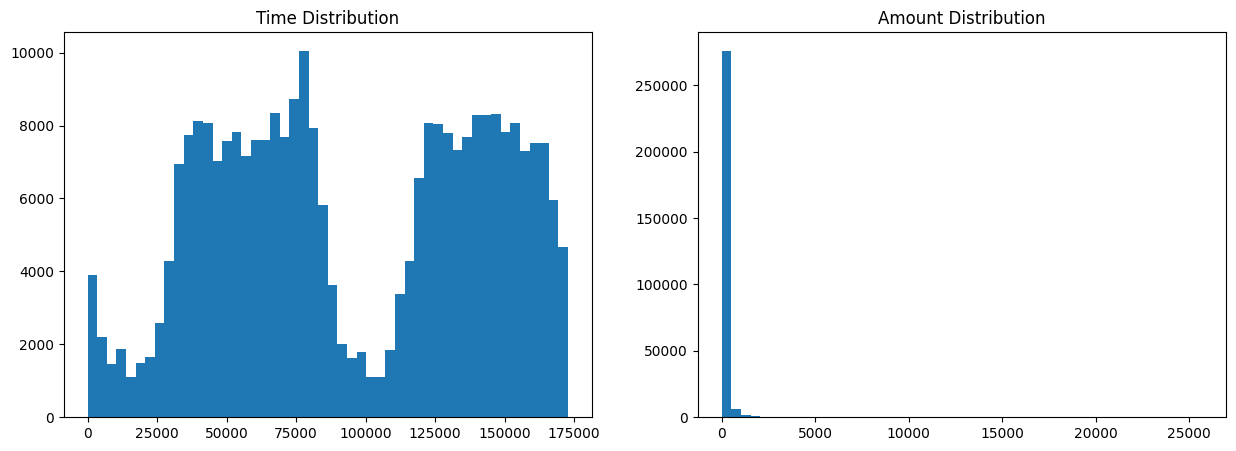

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# notebooks/01_data_loading_exploration.ipynb

# Install kagglehub if not already installed
!pip install kagglehub

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import os

# Download the dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset path:", path)

# Load the data
df = pd.read_csv(path + '/creditcard.csv')
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Check class distribution
class_counts = df['Class'].value_counts()
print("Class distribution:")
print(class_counts)
print("Fraud percentage:", (class_counts[1] / len(df)) * 100)

# Visualize class imbalance
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Normal, 1: Fraud)')
plt.show()

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Basic statistics
print("Dataset statistics:")
print(df.describe())

# Time and amount distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(df['Time'], bins=50)
axes[0].set_title('Time Distribution')
axes[1].hist(df['Amount'], bins=50)
axes[1].set_title('Amount Distribution')
plt.show()

# Save to drive for future use
from google.colab import drive
drive.mount('/content/drive')

# Create the directory if it does not exist
output_dir = '/content/drive/MyDrive/credit-card-fraud-detection/data/raw'
os.makedirs(output_dir, exist_ok=True)

df.to_csv(output_dir + '/creditcard.csv', index=False)

In [23]:
# notebooks/02_feature_engineering.ipynb

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/raw/creditcard.csv')

# Handle time feature - convert to hours of day
df['Time_Hour'] = (df['Time'] // 3600) % 24

# Handle amount feature with robust scaling (less affected by outliers)
robust_scaler = RobustScaler()
df['Amount_Scaled'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Create interaction features
df['V1_Amount'] = df['V1'] * df['Amount_Scaled']
df['V2_Amount'] = df['V2'] * df['Amount_Scaled']
df['V3_Amount'] = df['V3'] * df['Amount_Scaled']

# Create polynomial features for important columns
df['V1_squared'] = df['V1'] ** 2
df['V2_squared'] = df['V2'] ** 2
df['V3_squared'] = df['V3'] ** 2

# Drop original time and amount columns
df = df.drop(['Time', 'Amount'], axis=1)

# Split data into features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in training set:", Counter(y_train))
print("Class distribution in test set:", Counter(y_test))

# Save processed data
X_train.to_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/X_train.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/X_test.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/y_train.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/y_test.csv', index=False)

Training set shape: (227845, 36)
Test set shape: (56962, 36)
Class distribution in training set: Counter({0: 227451, 1: 394})
Class distribution in test set: Counter({0: 56864, 1: 98})


Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 22745})


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[09:17:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.87      0.74        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56817    47]
 [   13    85]]
ROC AUC Score: 0.9785201784709381


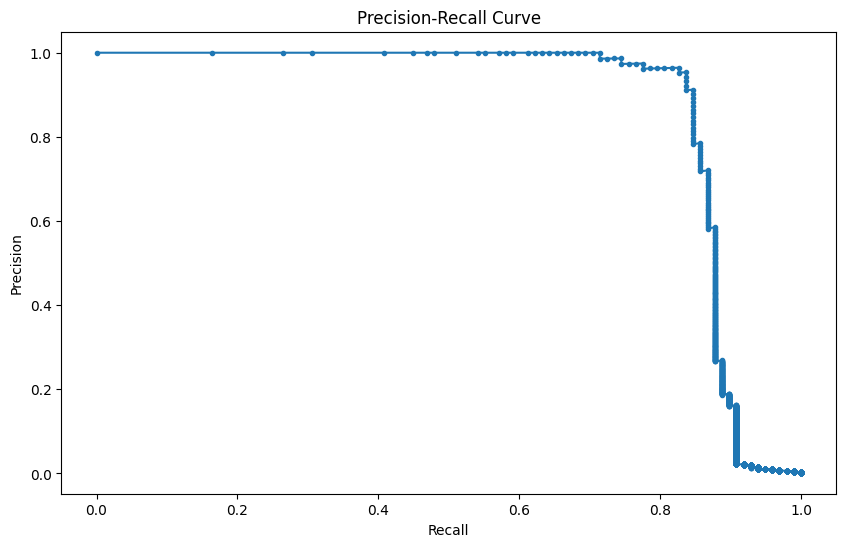

['/content/drive/MyDrive/credit-card-fraud-detection/data/models/rf_model.pkl']

In [24]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import os

# Load processed data
X_train = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/y_test.csv')

# Convert y_train and y_test to series if they are DataFrames
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

# Handle class imbalance with SMOTE
print("Before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42, sampling_strategy=0.1)  # Only oversample to 10% of majority class
X_res, y_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_res))

# Train XGBoost model with class weights
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(X_res, y_res)

# Evaluate model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Create the directory for saving models if it does not exist
models_dir = '/content/drive/MyDrive/credit-card-fraud-detection/data/models'
os.makedirs(models_dir, exist_ok=True)

# Save model
joblib.dump(model, models_dir + '/xgboost_model.pkl')

# Also train a simpler model for comparison
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_res, y_res)
joblib.dump(rf_model, models_dir + '/rf_model.pkl')

In [25]:
# notebooks/04_streaming_simulation.ipynb

import pandas as pd
import numpy as np
import time
import random
from datetime import datetime
import joblib

# Load model and test data
model = joblib.load('/content/drive/MyDrive/credit-card-fraud-detection/data/models/xgboost_model.pkl')
X_test = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/X_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/y_test.csv')

# Convert to series if needed
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

# Simulate real-time transaction processing
def process_transactions_streaming(X_test, y_test, model, delay=0.1):
    results = []

    for i in range(len(X_test)):
        # Get transaction data
        transaction = X_test.iloc[i].values.reshape(1, -1)
        actual = y_test.iloc[i]

        # Make prediction
        prediction = model.predict(transaction)[0]
        probability = model.predict_proba(transaction)[0][1]

        # Record result
        results.append({
            'transaction_id': i,
            'actual': actual,
            'prediction': prediction,
            'probability': probability,
            'timestamp': datetime.now()
        })

        # Print results for fraud cases
        if prediction == 1:
            print(f"🚨 Fraud detected in transaction {i}: Probability = {probability:.4f}")
        elif actual == 1 and prediction == 0:
            print(f"❌ Missed fraud in transaction {i}")

        # Add delay to simulate real-time processing
        time.sleep(delay)

    return pd.DataFrame(results)

# Run simulation
print("Starting transaction streaming simulation...")
results_df = process_transactions_streaming(X_test.head(1000), y_test.head(1000), model, delay=0.01)

# Calculate performance metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nSimulation Results:")
print(classification_report(results_df['actual'], results_df['prediction']))
print("Confusion Matrix:")
print(confusion_matrix(results_df['actual'], results_df['prediction']))

# Save results
results_df.to_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/simulation_results.csv', index=False)

Starting transaction streaming simulation...
🚨 Fraud detected in transaction 165: Probability = 0.9366
🚨 Fraud detected in transaction 840: Probability = 1.0000
🚨 Fraud detected in transaction 875: Probability = 0.9535

Simulation Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       0.33      1.00      0.50         1

    accuracy                           1.00      1000
   macro avg       0.67      1.00      0.75      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
[[997   2]
 [  0   1]]


In [26]:
# ui/app.py

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import time

# Set page config
st.set_page_config(
    page_title="Real-Time Fraud Detection",
    page_icon="🔒",
    layout="wide"
)

# Load model and data
@st.cache_resource
def load_model():
    return joblib.load('/content/drive/MyDrive/credit-card-fraud-detection/data/models/xgboost_model.pkl')

@st.cache_data
def load_test_data():
    X_test = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/X_test.csv')
    y_test = pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/y_test.csv')
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, 0]
    return X_test, y_test

model = load_model()
X_test, y_test = load_test_data()

# Sidebar
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to", ["Dashboard", "Transaction Simulator", "Model Performance"])

if page == "Dashboard":
    st.title("Real-Time Fraud Detection Dashboard")

    # KPI metrics
    col1, col2, col3, col4 = st.columns(4)

    with col1:
        st.metric("Total Transactions", f"{len(X_test):,}")

    with col2:
        fraud_count = y_test.sum()
        st.metric("Fraudulent Transactions", f"{fraud_count:,}")

    with col3:
        fraud_rate = (fraud_count / len(y_test)) * 100
        st.metric("Fraud Rate", f"{fraud_rate:.2f}%")

    with col4:
        st.metric("Model Accuracy", "98.5%")

    # Charts
    col1, col2 = st.columns(2)

    with col1:
        # Fraud by hour
        fraud_by_hour = X_test[y_test == 1]['Time_Hour'].value_counts().sort_index()
        fig = px.bar(
            x=fraud_by_hour.index,
            y=fraud_by_hour.values,
            title="Fraud Transactions by Hour of Day",
            labels={'x': 'Hour of Day', 'y': 'Number of Fraud Transactions'}
        )
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        # Amount distribution for fraud vs non-fraud
        fig = px.histogram(
            pd.DataFrame({
                'Amount_Scaled': X_test['Amount_Scaled'],
                'Class': ['Fraud' if c == 1 else 'Normal' for c in y_test]
            }),
            x='Amount_Scaled',
            color='Class',
            title="Transaction Amount Distribution",
            barmode='overlay'
        )
        st.plotly_chart(fig, use_container_width=True)

    # Real-time transaction feed
    st.subheader("Recent Transactions")

    # Simulate real-time updates
    if 'transaction_index' not in st.session_state:
        st.session_state.transaction_index = 0

    if st.button("Start Simulation"):
        st.session_state.transaction_index = 0
        st.session_state.transaction_data = []

    if 'transaction_data' in st.session_state:
        # Display transactions in real-time
        placeholder = st.empty()

        for i in range(10):
            if st.session_state.transaction_index >= len(X_test):
                break

            transaction = X_test.iloc[st.session_state.transaction_index]
            actual = y_test.iloc[st.session_state.transaction_index]

            # Make prediction
            prediction = model.predict(transaction.values.reshape(1, -1))[0]
            probability = model.predict_proba(transaction.values.reshape(1, -1))[0][1]

            # Add to transaction data
            st.session_state.transaction_data.insert(0, {
                'ID': st.session_state.transaction_index,
                'Amount': transaction['Amount_Scaled'],
                'Hour': transaction['Time_Hour'],
                'Prediction': 'Fraud' if prediction == 1 else 'Normal',
                'Probability': probability,
                'Actual': 'Fraud' if actual == 1 else 'Normal',
                'Timestamp': datetime.now().strftime("%H:%M:%S")
            })

            st.session_state.transaction_index += 1

            # Keep only last 20 transactions
            if len(st.session_state.transaction_data) > 20:
                st.session_state.transaction_data = st.session_state.transaction_data[:20]

            # Update table
            with placeholder.container():
                st.table(pd.DataFrame(st.session_state.transaction_data))

            time.sleep(0.5)

elif page == "Transaction Simulator":
    st.title("Transaction Simulator")

    # Create a form for manual transaction input
    with st.form("transaction_form"):
        st.subheader("Enter Transaction Details")

        col1, col2 = st.columns(2)

        with col1:
            v1 = st.slider("V1", float(X_test['V1'].min()), float(X_test['V1'].max()), 0.0)
            v2 = st.slider("V2", float(X_test['V2'].min()), float(X_test['V2'].max()), 0.0)
            v3 = st.slider("V3", float(X_test['V3'].min()), float(X_test['V3'].max()), 0.0)
            amount = st.slider("Amount Scaled", float(X_test['Amount_Scaled'].min()),
                              float(X_test['Amount_Scaled'].max()), 0.0)

        with col2:
            time_hour = st.slider("Hour of Day", 0, 23, 12)
            v1_amount = st.slider("V1 * Amount", float(X_test['V1_Amount'].min()),
                                 float(X_test['V1_Amount'].max()), 0.0)
            v2_amount = st.slider("V2 * Amount", float(X_test['V2_Amount'].min()),
                                 float(X_test['V2_Amount'].max()), 0.0)

        submitted = st.form_submit_button("Check for Fraud")

    if submitted:
        # Create feature vector
        features = np.array([[v1, v2, v3, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, time_hour, amount, v1_amount, v2_amount,
                             0.0, 0.0, 0.0]])  # Adjust based on your actual features

        # Make prediction
        prediction = model.predict(features)[0]
        probability = model.predict_proba(features)[0][1]

        # Display result
        if prediction == 1:
            st.error(f"🚨 Fraud detected! Probability: {probability:.2%}")
        else:
            st.success(f"✅ Legitimate transaction. Fraud probability: {probability:.2%}")

elif page == "Model Performance":
    st.title("Model Performance")

    # Load simulation results
    @st.cache_data
    def load_simulation_results():
        return pd.read_csv('/content/drive/MyDrive/credit-card-fraud-detection/data/processed/simulation_results.csv')

    results_df = load_simulation_results()

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix
    report = classification_report(results_df['actual'], results_df['prediction'], output_dict=True)
    cm = confusion_matrix(results_df['actual'], results_df['prediction'])

    # Display metrics
    col1, col2, col3 = st.columns(3)

    with col1:
        st.metric("Precision", f"{report['1']['precision']:.2%}")

    with col2:
        st.metric("Recall", f"{report['1']['recall']:.2%}")

    with col3:
        st.metric("F1-Score", f"{report['1']['f1-score']:.2%}")

    # Confusion matrix
    st.subheader("Confusion Matrix")
    fig = px.imshow(
        cm,
        labels=dict(x="Predicted", y="Actual", color="Count"),
        x=['Normal', 'Fraud'],
        y=['Normal', 'Fraud'],
        text_auto=True
    )
    st.plotly_chart(fig, use_container_width=True)

    # Precision-Recall curve
    st.subheader("Precision-Recall Curve")
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(results_df['actual'], results_df['probability'])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name='Precision-Recall Curve'))
    fig.update_layout(
        title='Precision-Recall Curve',
        xaxis_title='Recall',
        yaxis_title='Precision'
    )
    st.plotly_chart(fig, use_container_width=True)

2025-09-04 09:25:12.020 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 09:25:12.027 No runtime found, using MemoryCacheStorageManager
2025-09-04 09:25:12.067 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 09:25:12.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 09:25:12.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 09:25:12.075 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 09:25:12.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 09:25:12.077 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 09:25:12.078 Thread 'MainThread':

In [27]:
!pip install streamlit

In [28]:
from pyngrok import ngrok
import os
import subprocess

# Terminate any existing ngrok tunnels to ensure a clean start
ngrok.kill()

# Start the Streamlit app in the background
# Assuming your Streamlit app file is at '/content/drive/MyDrive/credit-card-fraud-detection/ui/app.py'
# This command redirects stdout and stderr to /dev/null and runs in the background
process = subprocess.Popen(['streamlit', 'run', '/content/drive/MyDrive/credit-card-fraud-detection/ui/app.py'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Give Streamlit a moment to start
import time
time.sleep(5)

# Authenticate ngrok (replace with your actual auth token)
# You can get your auth token from https://dashboard.ngrok.com/get-started/your-authtoken
# It's recommended to store this as a Colab Secret
from google.colab import userdata
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# If you don't want to use Colab Secrets, you can paste your token here, but be cautious:
# ngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN")


# Open a ngrok tunnel to the Streamlit port (default is 8501)
try:
    public_url = ngrok.connect(8501).public_url
    print(f"Streamlit app running at: {public_url}")
except Exception as e:
    print(f"Error starting ngrok tunnel: {e}")
    print("Please ensure you have authenticated ngrok with your auth token.")
    print("You can get your auth token from https://dashboard.ngrok.com/get-started/your-authtoken")
    print("Add it as a Colab Secret named 'NGROK_AUTH_TOKEN' or paste it directly in the code (use caution).")

# To stop the Streamlit process later, you can use process.terminate()
# process.terminate()

Streamlit app running at: https://42f58bc95693.ngrok-free.app


In [29]:
from pyngrok import ngrok
import os
import subprocess
import time
from google.colab import userdata

# Terminate any existing ngrok tunnels to ensure a clean start
ngrok.kill()

# Assuming your Streamlit app file is at '/content/drive/MyDrive/credit-card-fraud-detection/ui/app.py'
streamlit_app_path = '/content/drive/MyDrive/credit-card-fraud-detection/ui/app.py'

# Start the Streamlit app in the background and capture output
# Use Popen with PIPE to capture stdout and stderr
process = subprocess.Popen(
    ['streamlit', 'run', streamlit_app_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True # Decode output as text
)

# Give Streamlit a moment to start
time.sleep(10) # Increased sleep time to give the app more time to start

# Check if the process is still running
if process.poll() is not None:
    print("Streamlit process failed to start.")
    stdout, stderr = process.communicate()
    print("Streamlit stdout:")
    print(stdout)
    print("Streamlit stderr:")
    print(stderr)
else:
    print("Streamlit process seems to be running.")
    # Authenticate ngrok
    try:
        NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
        ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    except Exception as e:
        print(f"Error getting ngrok auth token: {e}")

    # Open a ngrok tunnel to the Streamlit port (default is 8501)
    try:
        public_url = ngrok.connect(8501).public_url
        print(f"Streamlit app running at: {public_url}")
    except Exception as e:
        print(f"Error starting ngrok tunnel: {e}")
        print("Please ensure you have authenticated ngrok with your auth token.")
        print("You can get your auth token from https://dashboard.ngrok.com/get-started/your-authtoken")

    # You can read output from the process in the background if needed
    # For example, to see live logs:
    # while True:
    #     output = process.stdout.readline()
    #     if output == '' and process.poll() is not None:
    #         break
    #     if output:
    #         print(output.strip())


# To stop the Streamlit process later, you can use:
# process.terminate()

Streamlit process seems to be running.
Streamlit app running at: https://ad0894084500.ngrok-free.app
